Reference:
https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold

https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/

https://www.kaggle.com/code/muhammetvarl/mlp-multiclass-classification-roc-auc/notebook

In [2]:
import pandas as pd
from smartlawdata import getSentenceTypeDataSet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
df_final1 = getSentenceTypeDataSet()
#print(df_final1)

los=[]
for item in df_final1['text']:
    los.append(item)

#Create a TFIDF vectorizer to generate text entered into vector form to be given as input to Machine Learning model
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(los)
feature_names = vectorizer.get_feature_names_out() #Extract the feature names as columns for the texts
dense = vectors.todense()
denselist = dense.tolist()
df_end = pd.DataFrame(denselist, columns=feature_names)
df_end['argumentSentenceType']=df_final1['argumentSentenceType']

yoriginal=df_end.argumentSentenceType
Xoriginal=df_end[feature_names]


In [3]:
# retrieve the model to be evaluate
def get_model():
	model = LogisticRegression()
	return model

In [4]:
# evaluate the model using a given test condition
def evaluate_model(cv):
	# get the dataset
	X, y = Xoriginal,yoriginal
	# get the model
	model = get_model()
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	# return scores
	return mean(scores), scores.min(), scores.max()

In [5]:
# calculate the ideal test condition
#ideal, _, _ = evaluate_model(LeaveOneOut())
#print('Ideal: %.3f' % ideal)
# define folds to test
folds = range(2,31)
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()
# evaluate each k value
for k in folds:
	# define the test condition
	cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
	# evaluate k value
	k_mean, k_min, k_max = evaluate_model(cv)
	# report performance
	print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
	# store mean accuracy
	means.append(k_mean)
	# store min and max relative to the mean
	mins.append(k_mean - k_min)
	maxs.append(k_max - k_mean)

> folds=2, accuracy=0.944 (0.943,0.945)
> folds=3, accuracy=0.942 (0.940,0.946)
> folds=4, accuracy=0.944 (0.941,0.948)
> folds=5, accuracy=0.943 (0.940,0.948)
> folds=6, accuracy=0.944 (0.936,0.951)
> folds=7, accuracy=0.944 (0.937,0.951)
> folds=8, accuracy=0.945 (0.936,0.951)
> folds=9, accuracy=0.944 (0.938,0.950)
> folds=10, accuracy=0.944 (0.935,0.953)
> folds=11, accuracy=0.945 (0.937,0.957)
> folds=12, accuracy=0.945 (0.936,0.955)
> folds=13, accuracy=0.944 (0.935,0.955)
> folds=14, accuracy=0.945 (0.932,0.959)
> folds=15, accuracy=0.944 (0.937,0.953)
> folds=16, accuracy=0.945 (0.928,0.958)
> folds=17, accuracy=0.944 (0.926,0.955)
> folds=18, accuracy=0.944 (0.933,0.958)
> folds=19, accuracy=0.945 (0.929,0.964)
> folds=20, accuracy=0.945 (0.925,0.963)
> folds=21, accuracy=0.945 (0.928,0.967)
> folds=22, accuracy=0.945 (0.928,0.962)
> folds=23, accuracy=0.945 (0.928,0.964)
> folds=24, accuracy=0.945 (0.925,0.963)
> folds=25, accuracy=0.945 (0.918,0.965)
> folds=26, accuracy=0.9

In [9]:
import json
#Save results
x = {
  "means":means,
  "mins":mins,
  "maxs":maxs
}

json_object = json.dumps(x, indent = 4)
import time
timestr = time.strftime("%Y%m%d-%H%M%S")  
filename="../temp/CVFoldDecision"+timestr+".json"  
# Writing to sample.json
with open(filename, "w") as outfile:
    outfile.write(json_object)

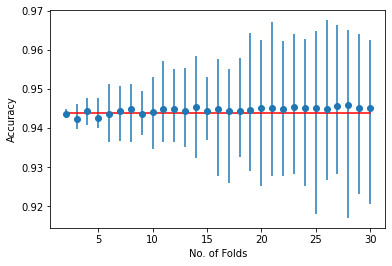

In [29]:
ideal=0.944

with open(filename,encoding="utf8") as f1: 
    cvFoldDecisionData=json.load(f1) #ALL DATA FROM FILE LOADED INTO DATA

means_from_file=cvFoldDecisionData["means"]
mins_from_file=cvFoldDecisionData["mins"]
maxs_from_file=cvFoldDecisionData["maxs"]

# line plot of k mean values with min/max error bars
pyplot.errorbar(folds, means_from_file, yerr=[mins_from_file, maxs_from_file], fmt='o')
# plot the ideal case in a separate color
pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r')


pyplot.xlabel('No. of Folds')
pyplot.ylabel('Accuracy')

pyplot.savefig("../temp/"+"CVFoldDecision.jpeg", format="jpeg", dpi=1200)

# show the plot
pyplot.show()